**Final Year Project**

**Syed Hammad Javed(F21-0634) & Fahad Akhlaq(F21-0631)**

**Supervised by: Dr Habib Akbar**

**Diabetic Retinopathy Binary Classification Using Custom CNN**

**Mounted google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Importing necessary Libraries**

In [ ]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import cohen_kappa_score
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

**Importing dataset**

In [ ]:
train_path = '/content/drive/MyDrive/aptos2019/train.csv'

In [ ]:
df = pd.read_csv(train_path)

In [ ]:
print("Original Diagnosis Value Counts:")
print(df['diagnosis'].value_counts())

Original Diagnosis Value Counts:
diagnosis
0    1805
2     999
1     370
4     295
3     193
Name: count, dtype: int64


**Converting Multi-Class to Binary Class**

In [ ]:
df['label'] = df['diagnosis'].apply(lambda x: 0 if x == 0 else 1)

In [ ]:
print("\nBinary Classification Label Counts:")
print(df['label'].value_counts())


Binary Classification Label Counts:
label
1    1857
0    1805
Name: count, dtype: int64


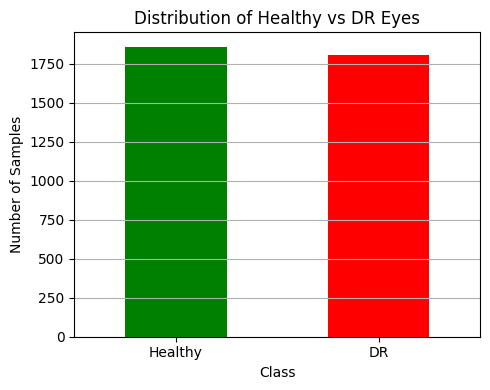

In [ ]:
plt.figure(figsize=(5, 4))
df['label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.xticks([0, 1], ['Healthy', 'DR'], rotation=0)
plt.title('Distribution of Healthy vs DR Eyes')
plt.ylabel('Number of Samples')
plt.xlabel('Class')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:


train_df, val_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['label'],
    random_state=42
)


print("Training set label distribution:")
print(train_df['label'].value_counts())


print("\nValidation set label distribution:")
print(val_df['label'].value_counts())


Training set label distribution:
label
1    1485
0    1444
Name: count, dtype: int64

Validation set label distribution:
label
1    372
0    361
Name: count, dtype: int64


In [ ]:
Train_images = '/content/drive/MyDrive/aptos2019/train_images'

In [ ]:


def show_samples(df, label, n=5):
    samples = df[df['label'] == label].sample(n)
    plt.figure(figsize=(15, 3))

    for i, row in enumerate(samples.itertuples()):
        img_path = os.path.join(Train_images, f"{row.id_code}.png")
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.title(f"{'No DR' if label == 0 else 'DR'}")
        plt.axis('off')
    plt.show()


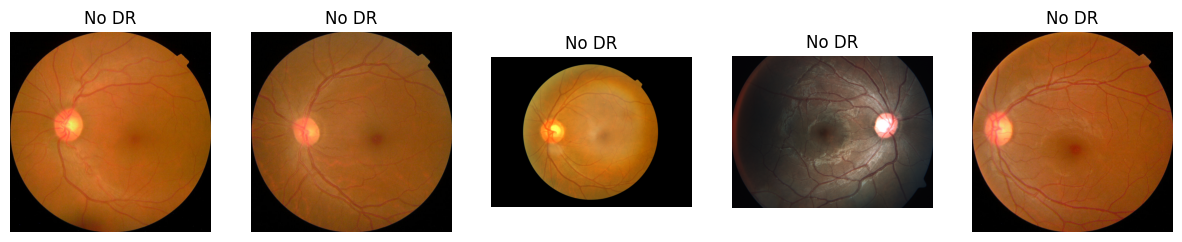

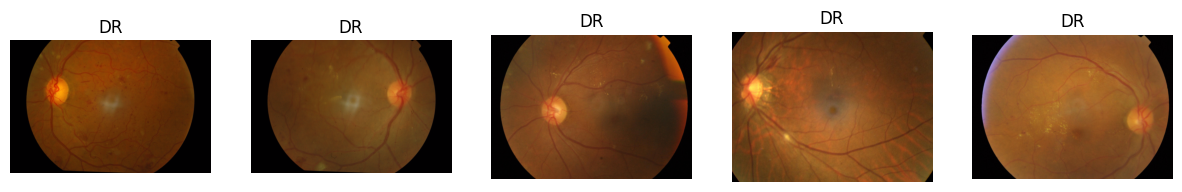

In [ ]:

show_samples(train_df, label=0, n=5)

show_samples(train_df, label=1, n=5)


**Preprocessing**

In [ ]:
IMG_SIZE = 300
BATCH_SIZE = 32

In [ ]:
def crop_image_from_gray(img, tol=7):

    if img.ndim == 2:  # grayscale
        mask = img > tol
        return img[np.ix_(mask.any(axis=1), mask.any(axis=0))]
    elif img.ndim == 3:  # RGB
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        check_shape = img[:, :, 0][np.ix_(mask.any(1), mask.any(0))].shape[0]
        if check_shape == 0:  # image too dark, return original
            return img
        else:
            img1 = img[:, :, 0][np.ix_(mask.any(axis=1), mask.any(axis=0))]
            img2 = img[:, :, 1][np.ix_(mask.any(axis=1), mask.any(axis=0))]
            img3 = img[:, :, 2][np.ix_(mask.any(axis=1), mask.any(axis=0))]
            img_cropped = np.stack([img1, img2, img3], axis=-1)
            return img_cropped


In [ ]:
def apply_clahe_rgb(img):
    """
    Applies CLAHE separately on each RGB channel.
    """
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    channels = cv2.split(img)
    clahe_channels = [clahe.apply(channel) for channel in channels]
    img_clahe = cv2.merge(clahe_channels)
    return img_clahe

In [ ]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = apply_clahe_rgb(img)
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img / 255.0

    return img

In [ ]:
def preprocess_and_show(img_path):
    # Load original image in RGB
    img_orig = cv2.imread(img_path)
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)

    # Crop black borders
    img_cropped = crop_image_from_gray(img_orig)

    # Apply CLAHE on cropped image
    img_clahe = apply_clahe_rgb(img_cropped)

    # Resize and normalize final image
    img_final = cv2.resize(img_clahe, (IMG_SIZE, IMG_SIZE)) / 255.0

    # Plot all steps
    plt.figure(figsize=(5, 5))

    plt.subplot(2, 2, 1)
    plt.imshow(img_orig)
    plt.title('Original')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(img_cropped)
    plt.title('Cropped')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(img_clahe)
    plt.title('Cropped + CLAHE')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(img_final)
    plt.title('Final: Resized + Normalized')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    return img_final


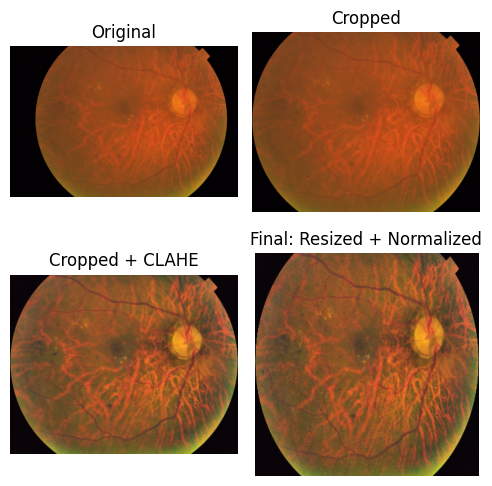

In [ ]:
sample_img_path = os.path.join(Train_images, f"{train_df.iloc[0].id_code}.png")
processed_img = preprocess_and_show(sample_img_path)


**Generating full Path Images**

In [ ]:
x_train = [os.path.join(Train_images, f"{img_id}.png") for img_id in train_df['id_code']]
x_val = [os.path.join(Train_images, f"{img_id}.png") for img_id in val_df['id_code']]

**Creating Numpy array to store preprocessed Images**

In [ ]:
train_images = np.empty((len(x_train), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
val_images = np.empty((len(x_val), IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)

In [ ]:
for i, path in enumerate(tqdm(x_train, desc="Preprocessing Train Images")):
    train_images[i] = preprocess_image(path)

Preprocessing Train Images: 100%|██████████| 2929/2929 [41:22<00:00,  1.18it/s]


In [ ]:
for i, path in enumerate(tqdm(x_val, desc="Preprocessing Validation Images")):
    val_images[i] = preprocess_image(path)

Preprocessing Validation Images: 100%|██████████| 733/733 [10:30<00:00,  1.16it/s]


In [ ]:
train_df.shape

(2929, 3)

In [ ]:
print("Shape of one image:", train_images[0].shape)
print("Data type:", train_images[0].dtype)

Shape of one image: (300, 300, 3)
Data type: float32


In [ ]:
y_train = train_df['label'].values
y_val = val_df['label'].values



**Model Architecture**

In [ ]:
model = Sequential([
    Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3,3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # sigmoid for binary classification
])

In [ ]:
class QWKCallback(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_images, val_labels = self.validation_data
        val_pred_prob = self.model.predict(val_images)
        val_pred = (val_pred_prob > 0.5).astype(int).flatten()
        val_true = val_labels.flatten()

        qwk = cohen_kappa_score(val_true, val_pred, weights='quadratic')
        print(f' - val_QWK: {qwk:.4f}')


In [ ]:
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

earlystop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

qwk_callback = QWKCallback(validation_data=(val_images, y_val))


In [ ]:
history = model.fit(
    train_images, y_train,
    validation_data=(val_images, y_val),
    epochs=30,
    batch_size=32,
    callbacks=[earlystop, checkpoint, qwk_callback]
)


Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.7842 - loss: 0.5156

23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
 - val_QWK: 0.8553
92/92 ━━━━━━━━━━━━━━━━━━━━ 752s 8s/step - accuracy: 0.7851 - loss: 0.5136 - val_accuracy: 0.9277 - val_loss: 0.2356
Epoch 2/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
 - val_QWK: 0.8310
92/92 ━━━━━━━━━━━━━━━━━━━━ 764s 8s/step - accuracy: 0.9205 - loss: 0.2155 - val_accuracy: 0.9154 - val_loss: 0.2791
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9370 - loss: 0.1900

23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step
 - val_QWK: 0.8471
92/92 ━━━━━━━━━━━━━━━━━━━━ 752s 8s/step - accuracy: 0.9369 - loss: 0.1902 - val_accuracy: 0.9236 - val_loss: 0.2214
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9390 - loss: 0.1814

23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
 - val_QWK: 0.8744
92/92 ━━━━━━━━━━━━━━━━━━━━ 779s 8s/step - accuracy: 0.9389 - loss: 0.1815 - val_accuracy: 0.9372 - val_loss: 0.2045
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9508 - loss: 0.1605

23/23 ━━━━━━━━━━━━━━━━━━━━ 44s 2s/step
 - val_QWK: 0.8662
92/92 ━━━━━━━━━━━━━━━━━━━━ 748s 8s/step - accuracy: 0.9508 - loss: 0.1606 - val_accuracy: 0.9332 - val_loss: 0.1940
Epoch 6/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step
 - val_QWK: 0.8772
92/92 ━━━━━━━━━━━━━━━━━━━━ 694s 8s/step - accuracy: 0.9564 - loss: 0.1426 - val_accuracy: 0.9386 - val_loss: 0.1991
Epoch 7/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step
 - val_QWK: 0.8744
92/92 ━━━━━━━━━━━━━━━━━━━━ 725s 7s/step - accuracy: 0.9505 - loss: 0.1496 - val_accuracy: 0.9372 - val_loss: 0.2154
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9580 - loss: 0.1325

23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
 - val_QWK: 0.8827
92/92 ━━━━━━━━━━━━━━━━━━━━ 731s 8s/step - accuracy: 0.9580 - loss: 0.1326 - val_accuracy: 0.9413 - val_loss: 0.1842
Epoch 9/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 46s 2s/step
 - val_QWK: 0.8827
92/92 ━━━━━━━━━━━━━━━━━━━━ 729s 8s/step - accuracy: 0.9658 - loss: 0.1125 - val_accuracy: 0.9413 - val_loss: 0.1959
Epoch 10/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 45s 2s/step
 - val_QWK: 0.8854
92/92 ━━━━━━━━━━━━━━━━━━━━ 795s 8s/step - accuracy: 0.9689 - loss: 0.1022 - val_accuracy: 0.9427 - val_loss: 0.2028
Epoch 11/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 43s 2s/step
 - val_QWK: 0.8854
92/92 ━━━━━━━━━━━━━━━━━━━━ 794s 8s/step - accuracy: 0.9683 - loss: 0.1011 - val_accuracy: 0.9427 - val_loss: 0.2087
Epoch 12/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
 - val_QWK: 0.8717
92/92 ━━━━━━━━━━━━━━━━━━━━ 767s 8s/step - accuracy: 0.9750 - loss: 0.0764 - val_accuracy: 0.9359 - val_loss: 0.2374
Epoch 13/30
23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
 - val_QWK: 0.8607
92/92 ━━━━━━━

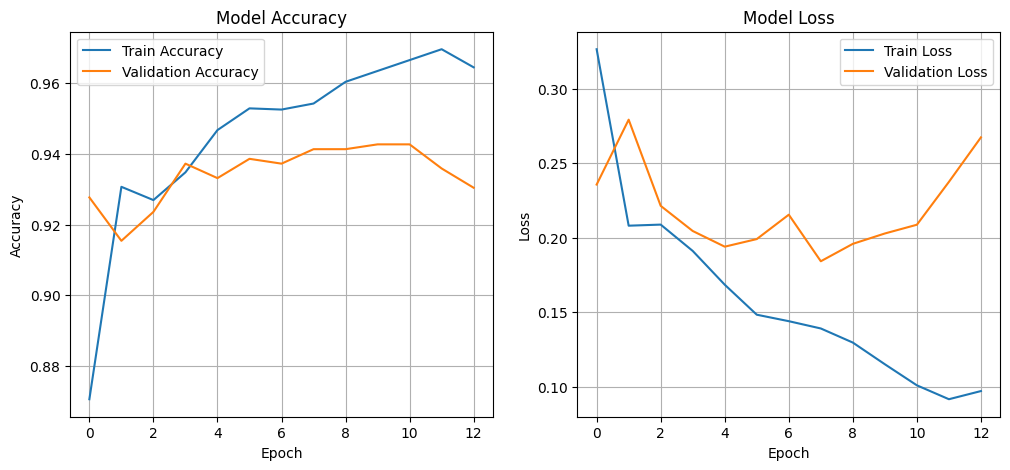

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.show()


23/23 ━━━━━━━━━━━━━━━━━━━━ 42s 2s/step
Validation Accuracy: 0.9413
Validation Precision: 0.9414
Validation Recall: 0.9413
Validation F1 Score: 0.9413


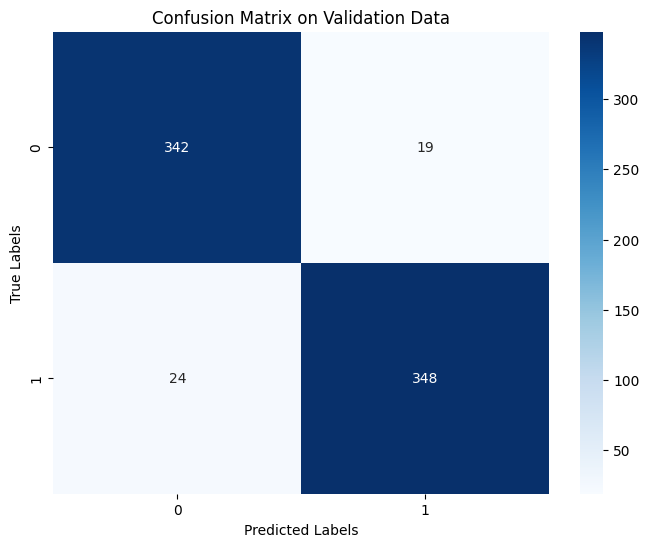

Classification Report on Validation Data:

              precision    recall  f1-score   support

           0       0.93      0.95      0.94       361
           1       0.95      0.94      0.94       372

    accuracy                           0.94       733
   macro avg       0.94      0.94      0.94       733
weighted avg       0.94      0.94      0.94       733



In [ ]:


y_pred_probs = model.predict(val_images)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = y_val
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted')
rec = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation Precision: {prec:.4f}")
print(f"Validation Recall: {rec:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# Step 3: Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix on Validation Data")
plt.show()

# Step 4: Print classification report
print("Classification Report on Validation Data:\n")
print(classification_report(y_true, y_pred))

In [ ]:
model.save("best_model.keras")

In [ ]:
import shutil

# ONLY zip the model file (223 MB expected)
shutil.make_archive('best_model', 'zip', root_dir='/content', base_dir='best_model.keras')


'/content/best_model.zip'

In [ ]:
import os

destination_folder = '/content/drive/MyDrive/binary_classification'
os.makedirs(destination_folder, exist_ok=True)


In [ ]:
shutil.move('best_model.keras', f'{destination_folder}/best_model.keras')

'/content/drive/MyDrive/binary_classification/best_model.keras'

In [ ]:
shutil.move('best_model.h5', f'{destination_folder}/best_model.h5')
shutil.move('best_model.zip', f'{destination_folder}/best_model.zip')

'/content/drive/MyDrive/binary_classification/best_model.zip'